# Agents

Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

<img src="agents.webp" width="800" height="300"/>

<img src="agents-flow.webp" width="800" height="500"/>

# Why LangGraph?

## Core Problems LangGraph Solves

* **Cycles & Loops**: Traditional chains are linear; agents need to iterate, retry, and loop back
* **State Management**: Agents need memory to track progress across complex workflows
* **Multi-Agent Coordination**: Complex tasks require multiple agents working together
* **Production Reliability**: Need persistence, error recovery, and human oversight

## Key Benefits

### Control & Flexibility

* Low-level orchestration without abstraction
* Full control over prompts, architecture, and decision flow
* Support for both workflows (predictable) and agents (autonomous)

### Production Features

* **Durable Execution**: Agents persist through failures and resume automatically
* **Human-in-the-Loop**: Add oversight and approval steps anywhere
* **Comprehensive Memory**: Short-term and long-term state management
* **Debugging**: Visual tools for tracing execution and state transitions

### Advanced Workflows

* **Cyclical Processes**: Agents can loop, reflect, and iterate
* **Multi-Agent**: Multiple specialized agents collaborate on complex tasks
* **Conditional Logic**: Dynamic routing based on agent decisions
* **Graph Structure**: Nodes (agents/functions) connected by edges (data flow)
  
## When to use LangGraph

**Use LangGraph for**:

* Complex, multi-step workflows
* Agents that need to iterate/retry
* Long-running processes
* Multi-agent systems
* Production deployments requiring reliability

**Use Simple LangChain for**:

* Linear question-answering
* Basic tool calling
* Quick prototypes
* Predictable workflows

In [1]:
!pip install langgraph

  Using cached xxhash-3.5.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (12 kB)
Using cached xxhash-3.5.0-cp39-cp39-macosx_11_0_arm64.whl (30 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [langgraph]


In [3]:
from langchain_openai import ChatOpenAI

llm_model="gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=llm_model)

In [4]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [15]:
from langgraph.graph import add_messages
from langgraph.func import entrypoint, task

from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    BaseMessage,
    ToolCall,
)

# nodes defined
# decision node, LLM decides whether to call a tool or not

@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke( 
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages # output saved to messages, this messages get accumulated as the llm calls different tools and gets the response
    )


@task # tool node, look at the last message and if that's a tool, then calls the tool
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)


@entrypoint() # start the agent - agent control flow
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()
    print("LLM:", llm_response)

    while True:
        if not llm_response.tool_calls: # Continues until tool call is not needed
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        print("Tools:", tool_results)

        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

# Invoke
messages = [HumanMessage(content="Add 3 and 4")]
chunks = agent.stream(messages)
chunks

<generator object Pregel.stream at 0x123c8f580>

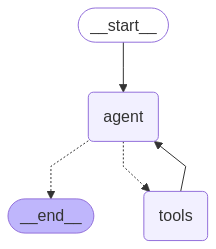

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_ZMfAp4EsrBezRNIaIUd10ubK)
 Call ID: call_ZMfAp4EsrBezRNIaIUd10ubK
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [14]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [17]:
messages = [HumanMessage(content="Add 3 and 4, then multiply by 2")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then multiply by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OJOcgi5AOZBa92I1eUTcBCra)
 Call ID: call_OJOcgi5AOZBa92I1eUTcBCra
  Args:
    a: 3
    b: 4
  multiply (call_2u1anaqdSnsIhIRJHCPPQjCw)
 Call ID: call_2u1anaqdSnsIhIRJHCPPQjCw
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_67O0DY7XaYi0jEGFbxnlLSPf)
 Call ID: call_67O0DY7XaYi0jEGFbxnlLSPf
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Fir

In [18]:
messages = [HumanMessage(content="Add 3 and 4, then multiply by 5, then divide it by 7")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then multiply by 5, then divide it by 7
================================== Ai Message ==================================
Tool Calls:
  add (call_9uXO6Y7E3kfcfl3ooMjcLX5b)
 Call ID: call_9uXO6Y7E3kfcfl3ooMjcLX5b
  Args:
    a: 3
    b: 4
  multiply (call_nudYSAE06xMJSDOtQkkYZxTy)
 Call ID: call_nudYSAE06xMJSDOtQkkYZxTy
  Args:
    a: 7
    b: 5
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

35
================================== Ai Message ==================================
Tool Calls:
  divide (call_zcL4cwoC4tYT2xCJFIwbcoWb)
 Call ID: call_zcL4cwoC4tYT2xCJFIwbcoWb
  Args:
    a: 35
    b: 7
================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ===================

# AI Research Automation System (Research Assistant)

Research automation represents one of AI's most promising applications, offering significant potential to streamline traditionally laborious analytical work. However, raw LLM outputs often fall short of real-world decision-making requirements, necessitating customized workflows that bridge this gap.

This specification outlines a lightweight, multi-agent system built around chat models that customizes the research process to deliver actionable insights

## Goal 
Build a lightweight, multi-agent system around chat models that customizes the research process for real-world decision-making workflows.

## System Components

### Source Selection
Users can choose any set of input sources for their research, providing flexibility in information gathering and ensuring relevance to specific domains or use cases.

### Planning
* Users provide a research topic
* The system generates a team of AI analysts, each focusing on one sub-topic
* Human-in-the-loop refinement allows users to adjust sub-topics before research begins

### LLM Utilization
* Each analyst conducts in-depth interviews with an expert AI using the selected sources
* Interviews follow a multi-turn conversation format to extract detailed insights (based on STORM paper methodology)
* Interview processes are captured using sub-graphs with their internal state

### Research Process
* Experts gather information to answer analyst questions in parallel
* All interviews are conducted simultaneously through map-reduce approach
* Parallel processing enables efficient scaling of research efforts

### Output Format
* Gathered insights from each interview are synthesized into a final report
* Customizable prompts allow for flexible output formatting
* Report structure adapts to specific use cases and decision-making requirements

In [19]:
import os
from dotenv import load_dotenv
 
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [20]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

In [21]:
!pip install tavily-python wikipedia

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11757 sha256=d241d69bfc9524927e54d9f73e4bd728d3a50be32014cccc0c3f1c009a4b64c7
  Stored in directory: /Users/thann/Library/Caches/pip/wheels/c2/46/f4/caa1bee71096d7b0cdca2f2a2af45cacf35c5760bee8f00948
Successfully built wikipedia
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tavily-python]


In [22]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
# Defines an Analyst data model with structured fields. The persona property formats all analyst information into a readable string for prompts.

# Perspectives: Container for multiple analysts (used for structured LLM output)
# GenerateAnalystsState: State schema for the analyst generation workflow

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

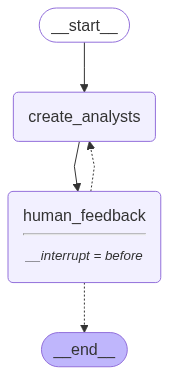

In [23]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges - Analyst generation workflow

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [24]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"

# Thread config for LangGraph state management - acts like a session ID 
# to track conversation state and enable resuming after interruptions

thread = {"configurable": {"thread_id": "1"}} 

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues such as data privacy, bias in AI decision-making, and the societal impacts of deploying AI agents built on this framework.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Intelligence Solutions
Role: Market Adoption Strategist
Description: Ms. Thompson analyzes the market trends and business benefits of adopting LangGraph. She focu

In [25]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [26]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f041378-18cb-6158-8002-78d65c707218'}}

In [27]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues such as data privacy, bias in AI decision-making, and the societal impacts of deploying AI agents built on this framework.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Intelligence Solutions
Role: Market Adoption Strategist
Description: Ms. Thompson analyzes the market trends and business benefits of adopting LangGraph. She focu

In [28]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f041379-7a69-6fda-8004-a3d613f85371'}}

In [29]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [30]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [31]:
final_state.next

()

In [32]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Jordan Lee
Affiliation: Tech Startup Incubator
Role: Startup Founder
Description: Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline agent development and enhance productivity in a startup environment. Their perspective emphasizes the agility and scalability of adopting new frameworks in fast-paced entrepreneurial settings.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: AI Research Institute
Role: AI Researcher
Description: Dr. Chen is a leading researcher in AI frameworks and their applications. She focuses on the technical benefits of LangGraph, including its architecture and performance improvements over traditional frameworks. Her insights are rooted in empirical research and aim to highlight the potential for innovation in AI development.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Corporate Technology Solutions
Role: Enterprise S

## Conduct Interview
### Generate Question
The analyst will ask questions to the expert.

In [33]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [34]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

## Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

Specific web sites e.g., via WebBaseLoader Indexed documents e.g., via RAG Web search Wikipedia search

You can try different web search tools, like Tavily.

In [35]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [36]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

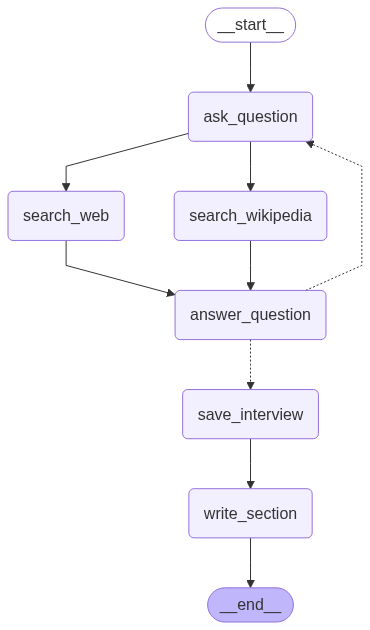

In [37]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [38]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Startup Incubator', name='Jordan Lee', role='Startup Founder', description='Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline agent development and enhance productivity in a startup environment. Their perspective emphasizes the agility and scalability of adopting new frameworks in fast-paced entrepreneurial settings.')

In [39]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Revolutionizing AI Development: The LangGraph Advantage for Startups

### Summary
In the rapidly evolving landscape of artificial intelligence, startups are increasingly seeking frameworks that can enhance their agility and scalability. LangGraph emerges as a powerful solution, particularly for tech startups focused on developing sophisticated AI agents. This framework offers several innovative features that streamline agent development, making it an attractive choice for entrepreneurs like Jordan, who aim to optimize productivity in a fast-paced environment.

One of the standout features of LangGraph is its **stateful orchestration**, which allows for the management of agent states and interactions seamlessly. This capability is crucial for maintaining context across complex processes, enabling startups to build more adaptable AI systems that can handle non-linear workflows. Unlike traditional linear frameworks, LangGraph supports **cyclic workflows**, allowing agents to revisit previous steps based on new information, thus enhancing their decision-making capabilities.

Moreover, LangGraph provides **fine-grained control** over agent workflows, enabling developers to create highly customized solutions tailored to specific business needs. This flexibility is particularly beneficial for startups that require rapid iterations and adjustments to their AI systems. The integration with multiple large language models (LLMs) at different stages of the workflow further enhances this adaptability, allowing agents to select the most suitable LLM for each task, whether it be tool invocation or content generation.

The framework's ability to support **dynamic APIs** and **fault-tolerant scalability** ensures that startups can deploy and scale their applications efficiently. This is particularly important in a startup environment where resources may be limited, and the ability to handle large workloads gracefully can significantly impact operational success.

Interestingly, while LangGraph offers powerful capabilities, it also introduces complexities in orchestration. Startups must navigate the challenges of designing effective agent workflows to avoid pitfalls such as agent looping. However, with the right guidance and expertise, these challenges can be effectively managed, leading to successful implementations that enhance user experience and drive ROI.

1. [Agency Revolutionizing AI Development](https://blog.agen.cy/p/agency-revolutionizing-ai-development)  
2. [Building Production-Ready AI Agents with LangGraph](https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4)  
3. [LangChain and LangGraph](https://www.langchain.com/langgraph)  
4. [AI Agents in LangGraph](https://www.rapidinnovation.io/post/ai-agents-in-langgraph)  
5. [Comparing Agent Frameworks](https://arize.com/blog-course/llm-agent-how-to-set-up/comparing-agent-frameworks/)  

### Sources
[1] https://blog.agen.cy/p/agency-revolutionizing-ai-development  
[2] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4  
[3] https://www.langchain.com/langgraph  
[4] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[5] https://arize.com/blog-course/llm-agent-how-to-set-up/comparing-agent-frameworks/  